In [1]:
import lancedb

In [2]:
def get_metadata_value(table, key_name, value_column="value"):
    """
    Retrieves a single value from a LanceDB table given a key.

    Args:
        table: The opened LanceDB table object.
        key_name: The string key to look for (e.g., 'tbl_img_emb').
        value_column: The name of the column containing the data.
    """
    # Filter for the key and select only the necessary column
    result = table.search().where(f"key='{key_name}'").select([value_column]).to_pandas()

    if not result.empty:
        return result[value_column].iloc[0]
    return None

In [3]:
embedding_db_path = "/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/experiments/era5"
source_img_path = "/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/shared_source"

project_name = "dinov3"
src_img_tbl_name = "era5_sample_images"

# Connect and open table
db = lancedb.connect(embedding_db_path)
source_db = lancedb.connect(source_img_path)
config_tbl = db.open_table(project_name + "_config")
img_emb_tbl = db.open_table(get_metadata_value(config_tbl, "img_emb_table_current"))
patch_emb_tbl = db.open_table(get_metadata_value(config_tbl, "patch_emb_table_current"))
src_img_tbl = source_db.open_table(src_img_tbl_name)

df = patch_emb_tbl.to_pandas()
df
# patch_emb_tbl.count_rows()

,patch_id,image_id,patch_index,embedding
0,2ab05a5c845ced5a7fdc93ad28f6bc73:0,2ab05a5c845ced5a7fdc93ad28f6bc73,0,"[0.035614014, -0.041748047, -0.00121212, -0.01..."
1,2ab05a5c845ced5a7fdc93ad28f6bc73:1,2ab05a5c845ced5a7fdc93ad28f6bc73,1,"[0.034454346, -0.051239014, -0.009155273, 0.00..."
2,2ab05a5c845ced5a7fdc93ad28f6bc73:2,2ab05a5c845ced5a7fdc93ad28f6bc73,2,"[0.0413208, -0.05618286, -0.015396118, -0.0031..."
3,2ab05a5c845ced5a7fdc93ad28f6bc73:3,2ab05a5c845ced5a7fdc93ad28f6bc73,3,"[0.026382446, -0.06488037, -0.004940033, -0.01..."
4,2ab05a5c845ced5a7fdc93ad28f6bc73:4,2ab05a5c845ced5a7fdc93ad28f6bc73,4,"[0.022720337, -0.06573486, -0.021896362, -0.02..."
...,...,...,...,...
280315,e02496c840f0966a59ac9ef1df802e31:251,e02496c840f0966a59ac9ef1df802e31,251,"[0.0034427643, -0.054382324, -0.0037899017, 0...."
280316,e02496c840f0966a59ac9ef1df802e31:252,e02496c840f0966a59ac9ef1df802e31,252,"[-0.006416321, -0.053375244, 0.0062789917, 0.0..."
280317,e02496c840f0966a59ac9ef1df802e31:253,e02496c840f0966a59ac9ef1df802e31,253,"[0.002193451, -0.053863525, -0.0071525574, 0.0..."
280318,e02496c840f0966a59ac9ef1df802e31:254,e02496c840f0966a59ac9ef1df802e31,254,"[-0.00013196468, -0.047454834, 0.023513794, 0...."


In [4]:
src_img_tbl.schema
# patch_emb_tbl= db.open_table(get_metadata_value(config_tbl, "patch_emb_table_current"))

id: string
filename: string
dt: timestamp[s]
image_blob: binary
thumb_blob: binary
-- schema metadata --
dataset_info: '{"dataset_name": "ERA5 Hurricane Training Data (RGB Compos' + 1339
version: '1.0'

In [5]:
patch_emb_tbl.schema

patch_id: string
image_id: string
patch_index: int32
embedding: fixed_size_list<item: float>[768]
  child 0, item: float

In [6]:
# CPU based

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Materialize embeddings to a contiguous float32 matrix
# X = np.asarray(df["embedding"].to_list(), dtype=np.float32)  # shape (N, 768)

# pca = PCA(n_components=768, svd_solver="randomized", random_state=0)
# pca.fit(X)

# cum = np.cumsum(pca.explained_variance_ratio_)

# plt.figure()
# plt.plot(np.arange(1, 769), cum)
# plt.xlabel("Number of principal components")
# plt.ylabel("Cumulative explained variance ratio")
# plt.ylim(0, 1.01)
# plt.grid(True)

# for t in [0.80, 0.90, 0.95, 0.99]:
#     k = int(np.searchsorted(cum, t) + 1)
#     plt.axhline(t, linestyle="--",color="red" )
#     plt.text(768 * 0.65, t + 0.01, f"{int(t*100)}% @ {k} PCs")

# plt.show()


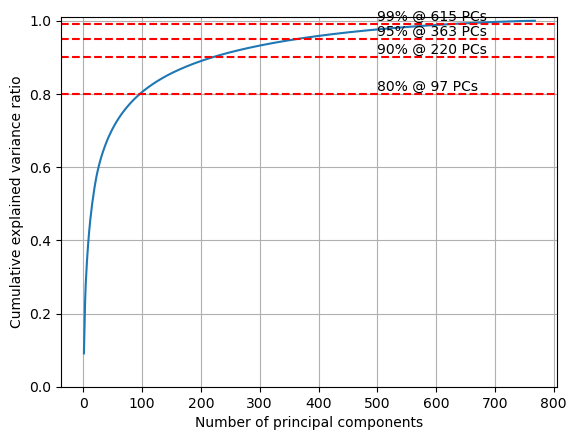

In [7]:
# GPU based

import matplotlib.pyplot as plt
import numpy as np
from cuml.decomposition import PCA

# Convert embeddings → contiguous float32 matrix
X = np.asarray(df["embedding"].to_list(), dtype=np.float32)

# GPU PCA
pca = PCA(n_components=768, output_type="numpy")
pca.fit(X)

# Cumulative explained variance
cum = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure()
plt.plot(np.arange(1, 769), cum)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance ratio")
plt.ylim(0, 1.01)
plt.grid(True)

for t in [0.80, 0.90, 0.95, 0.99]:
    k = int(np.searchsorted(cum, t) + 1)
    plt.axhline(t, linestyle="--", color="red")
    plt.text(768 * 0.65, t + 0.01, f"{int(t * 100)}% @ {k} PCs")

plt.show()

In [8]:
X = np.asarray(df["embedding"].to_list(), dtype=np.float32)  # (N, 768)
patch_ids = df["patch_id"].to_numpy()

In [9]:
from cuml.decomposition import PCA as cuPCA

pca = cuPCA(n_components=320, output_type="numpy")
X363 = pca.fit_transform(X).astype(np.float32)  # (N, 363)

In [10]:
import pandas as pd
from cuml.manifold import UMAP as cuUMAP

umap = cuUMAP(
    n_components=2,
    n_neighbors=30,  # tweak
    min_dist=0.05,  # tweak
    metric="cosine",
    output_type="numpy",
    random_state=42,
)
XY = umap.fit_transform(X363).astype(np.float32)  # (N, 2)

In [11]:
# Convert to Arrow, select columns, then to Pandas
img_df = src_img_tbl.to_arrow().select(["id", "dt"]).to_pandas()

# Ensure dtype and build lookup
img_df["dt"] = pd.to_datetime(img_df["dt"])

image_to_dt = dict(zip(img_df["id"], img_df["dt"], strict=False), strict=False)

In [12]:
patch_df = patch_emb_tbl.to_arrow().select(["image_id"]).to_pandas()

assert len(patch_df) == len(XY)

In [13]:
image_ids = patch_df["image_id"].values

# Vectorized mapping
dt_for_point = pd.Series(image_ids).map(image_to_dt).values

In [14]:
dt_series = pd.to_datetime(dt_for_point)

month_for_point = dt_series.month.astype("int8").values
doy_for_point = dt_series.dayofyear.astype("int16").values

In [15]:
df_xy = pd.DataFrame(
    {
        "x": XY[:, 0],
        "y": XY[:, 1],
        "month": pd.Categorical(month_for_point),
        "doy": doy_for_point,
    }
)

In [16]:
import datashader as ds
import holoviews as hv
import pandas as pd
import panel as pn
from holoviews.operation.datashader import datashade, dynspread

pn.extension()
hv.extension("bokeh")

# Points object
pts = hv.Points(df_xy, kdims=["x", "y"], vdims=["month", "doy"])


def make_plot(mode):
    if mode == "Month":
        color_key_month = {
            1: "#1f77b4",
            2: "#ff7f0e",
            3: "#2ca02c",
            4: "#d62728",
            5: "#9467bd",
            6: "#8c564b",
            7: "#e377c2",
            8: "#7f7f7f",
            9: "#bcbd22",
            10: "#17becf",
            11: "#aec7e8",
            12: "#ffbb78",
        }

        shaded = datashade(
            pts,
            aggregator=ds.count_cat("month"),
            color_key=color_key_month,
            width=3000,
            height=3000,
        )
        title = "UMAP Projection — Colored by Month"

    else:
        shaded = datashade(
            pts,
            aggregator=ds.mean("doy"),
            cmap="viridis",
            width=2000,
            height=2000,
        )
        title = "UMAP Projection — Colored by Day of Year"

    return dynspread(shaded).opts(
        width=1000,
        height=1000,
        bgcolor="#0e0e0e",
        show_grid=True,
        gridstyle={"grid_line_color": "#666666", "grid_line_alpha": 0.6},
        xlabel="UMAP-1",
        ylabel="UMAP-2",
        title=title,
    )


# Precompute both views
month_plot = make_plot("Month")
doy_plot = make_plot("Day of Year")

# Tabs layout - Assign to a variable and mark as servable
layout = pn.Tabs(
    ("Month", month_plot),
    ("DOY", doy_plot),
)

layout.servable()

Tabs
    [0] HoloViews(DynamicMap, height=1000, name='Month', sizing_mode='fixed', width=1000)
    [1] HoloViews(DynamicMap, height=1000, name='DOY', sizing_mode='fixed', width=1000)